## Sentiment Analysis of Tweets


## Import  Libraries

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import nltk
import pandas as pd
#from emoticons import EmoticonDetector
import re as regex
import numpy as np
#import plotly
#from plotly import graph_objs
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
#plotly.offline.init_notebook_mode()

import seaborn as sns
import plotly
import cufflinks as cf
import re

## Import the Data

In [3]:
train_data = pd.read_csv('data/Tweets.csv')
test_data = pd.read_csv('data/test.csv')

#train_data.rename(columns={'Category': 'emotion'}, inplace=True)
test_data.rename(columns={'Category': 'Tweet'}, inplace=True)

#train_data = train_data[train_data['emotion'] != 'Tweet']


In [4]:
train_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [6]:
test_data.head()

,Id,Tweet
0,6.289494e+17,dear @Microsoft the newOoffice for Mac is grea...
1,6.289766e+17,@Microsoft how about you make a system that do...
2,6.290232e+17,Not Available
3,6.291792e+17,Not Available
4,6.291863e+17,If I make a game as a #windows10 Universal App...


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9968 entries, 0 to 9967
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      4000 non-null   float64
 1   Tweet   4000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 155.9+ KB


# Data visualization

## Distribution of target class

<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

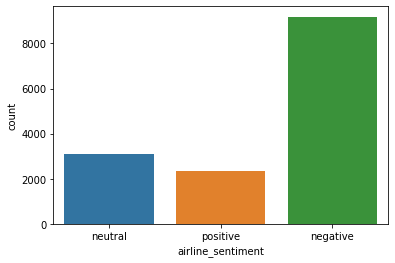

In [8]:
sns.countplot(x='airline_sentiment',data=train_data)

## Data Cleaning

In [9]:
# remove the tweets which contains Not available

train_data = train_data[train_data['text'] != "Not Available"]

### Function to clean tweets
Remove URLs
Remove usernames (mentions)
Remove tweets with Not Available text
Remove special characters
Remove numbers


In [10]:
def clean_tweets(tweet):
    
    # remove URL
    tweet = re.sub(r"http\S+", "", tweet)
    
    # Remove usernames
    tweet = re.sub(r"@[^\s]+[\s]?",'',tweet)
    
    # remove special characters 
    tweet = re.sub('[^ a-zA-Z0-9]', '', tweet)
    
    # remove Numbers
    tweet = re.sub('[0-9]', '', tweet)
    
    return tweet

In [11]:
# Apply function to Tweet column

train_data['text'] = train_data['text'].apply(clean_tweets)

In [12]:
train_data['text'].head()

0                                            What said
1    plus youve added commercials to the experience...
2    I didnt today Must mean I need to take another...
3    its really aggressive to blast obnoxious enter...
4              and its a really big bad thing about it
Name: text, dtype: object

## Tokenization & stemming

In [13]:
# Function which directly tokenize the tweet data
from nltk.tokenize import TweetTokenizer

tt = TweetTokenizer()
train_data['text'].apply(tt.tokenize)

0                                             [What, said]
1        [plus, youve, added, commercials, to, the, exp...
2        [I, didnt, today, Must, mean, I, need, to, tak...
3        [its, really, aggressive, to, blast, obnoxious...
4        [and, its, a, really, big, bad, thing, about, it]
                               ...                        
14635    [thank, you, we, got, on, a, different, flight...
14636    [leaving, over, minutes, Late, Flight, No, war...
14637    [Please, bring, American, Airlines, to, BlackB...
14638    [you, have, my, money, you, change, my, flight...
14639    [we, have, ppl, so, we, need, know, how, many,...
Name: text, Length: 14640, dtype: object

In [14]:
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

ps = PorterStemmer()

In [15]:
def tokenize(text):
    return word_tokenize(text)

def stemming(words):
    stem_words = []
    for w in words:
        w = ps.stem(w)
        stem_words.append(w)
    
    return stem_words

In [17]:
# apply tokenize function
train_data['text'] = train_data['text'].apply(tokenize)

In [18]:
# apply steming function
train_data['tokenized'] = train_data['text'].apply(stemming)

In [19]:
train_data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,tokenized
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,"[What, said]",NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),"[what, said]"
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,"[plus, youve, added, commercials, to, the, exp...",NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),"[plu, youv, ad, commerci, to, the, experi, tacki]"
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,"[I, didnt, today, Must, mean, I, need, to, tak...",NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),"[I, didnt, today, must, mean, I, need, to, tak..."
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,"[its, really, aggressive, to, blast, obnoxious...",NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"[it, realli, aggress, to, blast, obnoxi, enter..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,"[and, its, a, really, big, bad, thing, about, it]",NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),"[and, it, a, realli, big, bad, thing, about, it]"


## Wordlist

In [20]:
words = Counter()
for idx in train_data.index:
    words.update(train_data.loc[idx, "text"])

words.most_common(5)

[('to', 8586), ('the', 5797), ('I', 5072), ('a', 4384), ('for', 3948)]

In [21]:
stopwords=nltk.corpus.stopwords.words("english")

In [22]:
whitelist = ["n't", "not"]
for idx, stop_word in enumerate(stopwords):
    if stop_word not in whitelist:
        del words[stop_word]
words.most_common(5)

[('I', 5072),
 ('flight', 3156),
 ('not', 1396),
 ('get', 1297),
 ('Cancelled', 1056)]

In [23]:
def word_list(processed_data):
    #print(processed_data)
    min_occurrences=3 
    max_occurences=500 
    stopwords=nltk.corpus.stopwords.words("english")
    whitelist = ["n't","not"]
    wordlist = []
    
    whitelist = whitelist if whitelist is None else whitelist
    #print(whitelist)
    '''
    import os
    if os.path.isfile("wordlist.csv"):
        word_df = pd.read_csv("wordlist.csv")
        word_df = word_df[word_df["occurrences"] > min_occurrences]
        wordlist = list(word_df.loc[:, "word"])
        #return
    '''
    words = Counter()
    for idx in processed_data.index:
        words.update(processed_data.loc[idx, "text"])

    for idx, stop_word in enumerate(stopwords):
        if stop_word not in whitelist:
            del words[stop_word]
    #print(words)

    word_df = pd.DataFrame(data={"word": [k for k, v in words.most_common() if min_occurrences < v < max_occurences],
                                 "occurrences": [v for k, v in words.most_common() if min_occurrences < v < max_occurences]},
                           columns=["word", "occurrences"])
    #print(word_df)
    word_df.to_csv("wordlist.csv", index_label="idx")
    wordlist = [k for k, v in words.most_common() if min_occurrences < v < max_occurences]
    #print(wordlist)

In [24]:
word_list(train_data)

In [25]:
words = pd.read_csv("wordlist.csv")

## Bag of Words

In [26]:
import os

In [28]:
wordlist= []
if os.path.isfile("wordlist.csv"):
    word_df = pd.read_csv("wordlist.csv")
    word_df = word_df[word_df["occurrences"] > 3]
    wordlist = list(word_df.loc[:, "word"])

label_column = ["label"]
columns = label_column + list(map(lambda w: w + "_bow",wordlist))
labels = []
rows = []
for idx in train_data.index:
    current_row = []
    
    # add label
    current_label = train_data.loc[idx, "airline_sentiment"]
    labels.append(current_label)
    current_row.append(current_label)

    # add bag-of-words
    tokens = set(train_data.loc[idx, "text"])
    for _, word in enumerate(wordlist):
        current_row.append(1 if word in tokens else 0)

    rows.append(current_row)

data_model = pd.DataFrame(rows, columns=columns)
data_labels = pd.Series(labels)


bow = data_model

## Classification

In [29]:
import random
seed = 777
random.seed(seed)


In [30]:
def test_classifier(X_train, y_train, X_test, y_test, classifier):
    log("")
    log("---------------------------------------------------------")
    log("Testing " + str(type(classifier).__name__))
    now = time()
    list_of_labels = sorted(list(set(y_train)))
    model = classifier.fit(X_train, y_train)
    log("Learing time {0}s".format(time() - now))
    now = time()
    predictions = model.predict(X_test)
    log("Predicting time {0}s".format(time() - now))

    # Calculate Accuracy, Precision, recall
    
    precision = precision_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    recall = recall_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average=None, pos_label=None, labels=list_of_labels)
    
    log("=================== Results ===================")
    log("            Negative     Neutral     Positive")
    log("F1       " + str(f1))
    log("Precision" + str(precision))
    log("Recall   " + str(recall))
    log("Accuracy " + str(accuracy))
    log("===============================================")

    return precision, recall, accuracy, f1

def log(x):
    #can be used to write to log file
    print(x)


# Polarity - BOW Model  

# Naive Bayes

In [31]:
from sklearn.naive_bayes import BernoulliNB
X_train, X_test, y_train, y_test = train_test_split(bow.iloc[:, 1:], bow['label'], test_size=0.3)
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, BernoulliNB())


---------------------------------------------------------
Testing BernoulliNB
Learing time 1.455106496810913s
Predicting time 0.6515891551971436s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.85008818 0.57301499 0.6351866 ]
Precision[0.82988981 0.59515571 0.67149758]
Recall   [0.87129429 0.55246253 0.60260116]
Accuracy 0.7611566484517304


In [36]:
nb_acc = accuracy

## Random Forest

In [35]:
from sklearn.ensemble import RandomForestClassifier
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, RandomForestClassifier(random_state=seed,n_estimators=403,n_jobs=-1))



---------------------------------------------------------
Testing RandomForestClassifier
Learing time 83.41114258766174s
Predicting time 1.8760335445404053s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.84316142 0.54254144 0.60170147]
Precision[0.82161235 0.56050228 0.64725458]
Recall   [0.86587129 0.52569593 0.56213873]
Accuracy 0.7456739526411658


In [37]:
rf_acc = accuracy

In [38]:
rf_acc

0.7456739526411658

## XGBoost

In [39]:
from xgboost import XGBClassifier as XGBoostClassifier

In [40]:
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, XGBoostClassifier(seed=seed))


---------------------------------------------------------
Testing XGBClassifier
Learing time 359.2737820148468s
Predicting time 0.6608796119689941s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.82091178 0.35909446 0.55947955]
Precision[0.72056815 0.66282421 0.78385417]
Recall   [0.95372379 0.24625268 0.4349711 ]
Accuracy 0.7215391621129326


In [41]:
xgb_acc = accuracy

## Decision Tree Classifier

In [42]:
from sklearn import tree
precision, recall, accuracy, f1 = test_classifier(X_train, y_train, X_test, y_test, tree.DecisionTreeClassifier())


---------------------------------------------------------
Testing DecisionTreeClassifier
Learing time 17.967511653900146s
Predicting time 0.07171750068664551s
=================== Results ===================
            Negative     Neutral     Positive
F1       [0.79544201 0.49260581 0.52098408]
Precision[0.80897196 0.47030185 0.52173913]
Recall   [0.78235719 0.51713062 0.52023121]
Accuracy 0.6846539162112932


In [43]:
dt_acc = accuracy

# LSTM - RNN

In [59]:
df= pd.read_csv('data/Tweets.csv', sep=',')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [60]:
# Attribute and Labels
tweet_df = df[['text','airline_sentiment']]
tweet_df = tweet_df[tweet_df['airline_sentiment'] != 'neutral']
X = tweet_df.text
y = tweet_df.airline_sentiment

In [61]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [62]:
# Getting required labels only and encoding

review_labels_train = y_train.factorize()

In [63]:
# Check Review Labels
review_labels_train[1]

Index(['negative', 'positive'], dtype='object')

In [64]:
# Importing required tf modules
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
vocab = X_train.values

In [65]:
# Vectorize a text corpus, by turning each text into sequence of integers

tokenizer = Tokenizer(num_words=8000,oov_token='OOV')
tokenizer.fit_on_texts(vocab)

vocab_size = len(tokenizer.word_index) + 1

print(tokenizer)
print(vocab_size)

11636


In [66]:
# Store and Padding Converted Sequences
tweet = X_train.values

tweet_seqs = tokenizer.texts_to_sequences(tweet)

padded_sequence_train = pad_sequences(tweet_seqs, maxlen=200)
print(padded_sequence_train)

[[   0    0    0 ... 3560  364  141]
 [   0    0    0 ...   76  196  754]
 [   0    0    0 ...  304   79  354]
 ...
 [   0    0    0 ...   48   50    1]
 [   0    0    0 ...   32   57  353]
 [   0    0    0 ...    3 4197  569]]


In [67]:
print(padded_sequence_train[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0   13  143 1590  549   57  122  660  221 2105
   59  752   57  428   20    3  257  855    4  224   81 5034 3559 5035
 2830 

In [68]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding

embedding_vector_length = 32

model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           372352    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                16600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 389,003
Trainable params: 389,003
Non-trainable params: 0
_________________________________________________________________
None


In [70]:
trained = model.fit(padded_sequence_train,review_labels_train[0],
                  validation_split=0.2, epochs=20, batch_size=32)

231/231 [==============================] - 501s 2s/step - loss: 0.2530 - accuracy: 0.9009 - val_loss: 0.2484 - val_accuracy: 0.9042


In [71]:
encoded_docs = tokenizer.texts_to_sequences(X_test)
padded_sequence_test = pad_sequences(encoded_docs, maxlen=200)
print(padded_sequence_test)

[[   0    0    0 ...   10    1   18]
 [   0    0    0 ...   48   50    1]
 [   0    0    0 ...    2 6450  529]
 ...
 [   0    0    0 ...   99    3  314]
 [   0    0    0 ... 1542   91    1]
 [   0    0    0 ...  200  106   30]]


In [72]:
sentiment_label_test = y_test.factorize()
sentiment_label_test[0]

array([0, 1, 0, ..., 0, 1, 0])

In [73]:
score = model.evaluate(padded_sequence_test,sentiment_label_test[0],verbose=0)

In [74]:
lstm_acc = score[1]
lstm_acc

0.9216110706329346

In [75]:
score = [nb_acc,rf_acc,xgb_acc,dt_acc,lstm_acc]

In [76]:
#make variabel for save the result and to show it
classifier = ('Naive Bayes with BOW','Random Forest with BOW','XGB with BOW','DT with BOW','LSTM-RNN')
y_pos = np.arange(len(classifier))
print(y_pos)
print(score)

[0 1 2 3 4]
[0.7456739526411658, 0.7456739526411658, 0.7215391621129326, 0.6846539162112932, 0.9216110706329346]


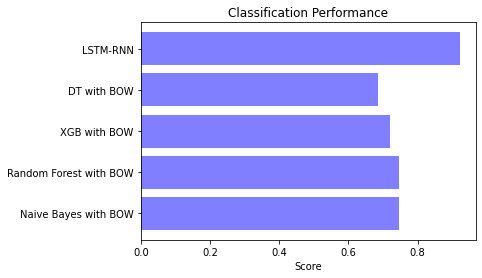

In [82]:
import matplotlib.pyplot as plt2
plt2.barh(y_pos, score, align='center', alpha=0.5,color='blue')
plt2.yticks(y_pos, classifier)
plt2.xlabel('Score')
plt2.title('Classification Performance')
plt2.show()

In [83]:
model.save('sentiment.h5')

Here we used Polarity BOW model with mergering with Machine learning for analysis and then we use LSTM for same data 
finally comparing which is giving better accuracy for user prediction